#### 1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке).
#### 2. Повторить п.1, но используя уже не медиану, а max.
#### 3. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score.
#### 4. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.

In [91]:
import pandas as pd
import numpy as np

from gensim.corpora.dictionary import Dictionary

import re

from nltk.corpus import stopwords
import nltk

from razdel import tokenize

import pymorphy2

import itertools 

In [92]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Professional\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [94]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [95]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [96]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [97]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [98]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 21.8 s


In [99]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 3s


In [100]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [101]:
common_dictionary[10]

'ватутин'

In [102]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 27.1 s


In [103]:
from gensim.test.utils import datapath

temp_file = datapath("model.lda")
lda.save(temp_file)

lda = LdaModel.load(temp_file)

In [104]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.25989532), (3, 0.023373872), (17, 0.13964781), (18, 0.55826104)]

In [105]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: это который мочь весь год всё свой
topic_1: китай китайский форум японский япония золото японец
topic_2: продукция тыс белый цена остров продолжительность компания
topic_3: океан лауреат лодка устанавливать мобильный зуб телефон
topic_4: год человек тыс млн который женщина тело
topic_5: который это научный человек год район мочь
topic_6: станция территория город участок аэропорт объект житель
topic_7: год который это nn решение суд новый
topic_8: отряд трансляция снежный диск пролететь кит застрять
topic_9: газ украина год армия восток украинский военный
topic_10: сша гражданин обнаружить американский это товар народный
topic_11: год млрд проект рубль рынок развитие объём
topic_12: университет nn космос фестиваль высота который солнце
topic_13: ракета год миссия земля налог век это
topic_14: наука ребёнок это который свой весь год
topic_15: рак фильм вуз ресторан nn игра хороший
topic_16: треть лётчик остаток звонок репутация ливия воспаление
topic_17: фонд поверхность активно

In [106]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [107]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.034977,0.0,0.011359,0.000000,0.634497,0.104963,0.197420,0.000000,0.0,0.0
1,4896,0.000000,0.0,0.0,0.000000,0.429786,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.185900,0.000000,0.000000,0.171335,0.000000,0.000000,0.0,0.0
2,4897,0.259866,0.0,0.0,0.023374,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.139647,0.558291,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,4898,0.475301,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.084636,0.092658,0.000000,0.000000,0.337357,0.000000,0.0,0.0
4,4899,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.028239,...,0.000000,0.0,0.000000,0.000000,0.098565,0.000000,0.410433,0.439389,0.0,0.0


In [108]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [109]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [110]:
doc_dict[293622]

array([0.        , 0.        , 0.05715605, 0.01950588, 0.        ,
       0.06099853, 0.        , 0.15567361, 0.        , 0.05127119,
       0.0278205 , 0.        , 0.        , 0.        , 0.        ,
       0.04909111, 0.        , 0.        , 0.20877165, 0.        ,
       0.11363354, 0.24696636, 0.        , 0.        , 0.        ])

In [111]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [112]:
get_user_embedding(user_articles_list)

array([0.04590323, 0.        , 0.00395819, 0.00420115, 0.08244362,
       0.07343182, 0.00360205, 0.10122448, 0.00178147, 0.04047737,
       0.01217899, 0.03262055, 0.0215764 , 0.00859856, 0.03254505,
       0.        , 0.00318132, 0.        , 0.0321695 , 0.03740118,
       0.25196073, 0.16000279, 0.        , 0.        , 0.03911086])

In [113]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.023211,0.0,0.045964,0.003251,0.114946,0.083101,0.019059,0.146542,0.014493,...,0.008182,0.0,0.000000,0.039028,0.004772,0.042116,0.147020,0.000000,0.000000,0.006000
1,u108690,0.134327,0.0,0.005685,0.000000,0.060544,0.129112,0.000000,0.026363,0.000000,...,0.006933,0.0,0.005690,0.017262,0.056134,0.228683,0.083741,0.011512,0.004385,0.013103
2,u108339,0.012394,0.0,0.005079,0.000000,0.132289,0.153630,0.012098,0.105554,0.000000,...,0.000000,0.0,0.002747,0.015815,0.098038,0.092839,0.120947,0.000000,0.013147,0.063913


In [114]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [115]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.023211,0.0,0.045964,0.003251,0.114946,0.083101,0.019059,0.146542,0.014493,...,0.0,0.000000,0.039028,0.004772,0.042116,0.147020,0.000000,0.000000,0.006000,0
1,u108690,0.134327,0.0,0.005685,0.000000,0.060544,0.129112,0.000000,0.026363,0.000000,...,0.0,0.005690,0.017262,0.056134,0.228683,0.083741,0.011512,0.004385,0.013103,1
2,u108339,0.012394,0.0,0.005079,0.000000,0.132289,0.153630,0.012098,0.105554,0.000000,...,0.0,0.002747,0.015815,0.098038,0.092839,0.120947,0.000000,0.013147,0.063913,1


In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [118]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [119]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11521505, 0.16485917, 0.26209737, 0.11989076, 0.00871899,
       0.07709666, 0.11875538, 0.09196872, 0.16594446, 0.0856914 ])

In [120]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Метрики, рассчитанные в функции get_user_embedding при помощи метода mean обозначик через precision_0, recall_0, fscore_0 и roc_auc_0.

In [121]:
precision_0, recall_0, thresholds = precision_recall_curve(y_test, preds)
fscore_0 = (2 * precision_0 * recall_0) / (precision_0 + recall_0)
ix = np.argmax(fscore_0)
print('Best Threshold=%f, F-Score_0=%.3f, Precision_0=%.3f, Recall_0=%.3f' % (thresholds[ix], 
                                                                        fscore_0[ix],
                                                                        precision_0[ix],
                                                                        recall_0[ix]))

Best Threshold=0.241038, F-Score_0=0.681, Precision_0=0.615, Recall_0=0.763


In [122]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1638  117]
 [  59  186]]


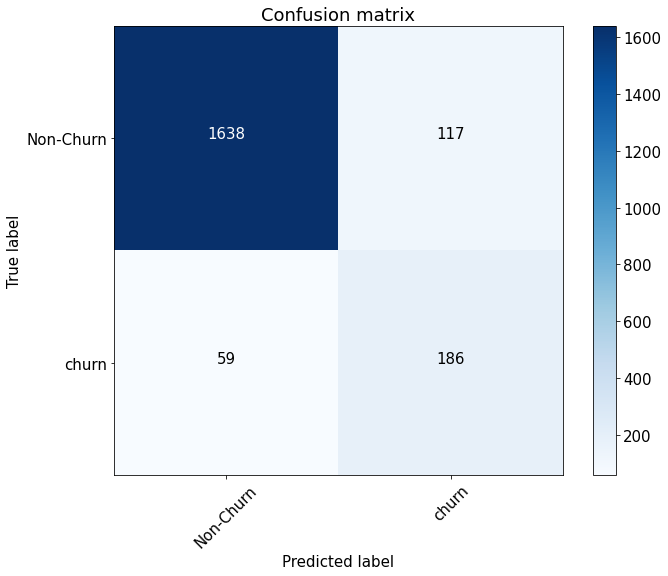

In [123]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [125]:
roc_auc_0 = roc_auc_score(y_test, preds)

roc_auc_0

0.9434874120588406

Изменим в функции get_user_embedding метод расчета при помощи np.median и рассчетаем precision_1, recall_1, fscore_1 и roc_auc_1.

In [126]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [127]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03848875, 0.        , 0.06586381, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00880867,
       0.        , 0.        , 0.        , 0.01690381, 0.02926012,
       0.2286824 , 0.13741181, 0.        , 0.        , 0.02208481])

In [128]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.0,0.0,0.079703,0.030499,0.00000,0.110799,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.156375,0.0,0.0,0.000000
1,u108690,0.165353,0.0,0.0,0.0,0.056651,0.075011,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.008375,0.072543,0.170386,0.077088,0.0,0.0,0.000000
2,u108339,0.000000,0.0,0.0,0.0,0.075777,0.183058,0.00837,0.079166,0.0,...,0.0,0.0,0.0,0.012302,0.060915,0.063669,0.096739,0.0,0.0,0.068301


In [129]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [130]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.0,0.0,0.079703,0.030499,0.00000,0.110799,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.156375,0.0,0.0,0.000000,0
1,u108690,0.165353,0.0,0.0,0.0,0.056651,0.075011,0.00000,0.000000,0.0,...,0.0,0.0,0.008375,0.072543,0.170386,0.077088,0.0,0.0,0.000000,1
2,u108339,0.000000,0.0,0.0,0.0,0.075777,0.183058,0.00837,0.079166,0.0,...,0.0,0.0,0.012302,0.060915,0.063669,0.096739,0.0,0.0,0.068301,1


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [132]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [134]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03998301, 0.15678507, 0.39374845, 0.13745748, 0.01147753,
       0.08120833, 0.0548509 , 0.1342745 , 0.11223256, 0.20730839])

In [135]:
precision_1, recall_1, thresholds = precision_recall_curve(y_test, preds)
fscore_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
ix = np.argmax(fscore_1)
print('Best Threshold=%f, F-Score_1=%.3f, Precision_1=%.3f, Recall_1=%.3f' % (thresholds[ix], 
                                                                        fscore_1[ix],
                                                                        precision_1[ix],
                                                                        recall_1[ix]))

Best Threshold=0.254197, F-Score_1=0.757, Precision_1=0.699, Recall_1=0.824


In [136]:
roc_auc_1 = roc_auc_score(y_test, preds)

roc_auc_1

0.969423803709518

Изменим в функции get_user_embedding метод расчета при помощи np.max и рассчетаем precision_2, recall_2, fscore_2 и roc_auc_2.

In [137]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [138]:
get_user_embedding(user_articles_list)

array([0.20998657, 0.        , 0.02374912, 0.02520693, 0.32457253,
       0.18432422, 0.02161232, 0.36836144, 0.01068881, 0.1351577 ,
       0.04802605, 0.10418096, 0.12945843, 0.05159139, 0.14308986,
       0.        , 0.0190879 , 0.        , 0.11323313, 0.08461285,
       0.52875155, 0.44754666, 0.        , 0.        , 0.1120244 ])

In [139]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.095170,0.0,0.218625,0.019506,0.314576,0.250129,0.083827,0.372325,0.086957,...,0.049091,0.0,0.000000,0.208772,0.028630,0.139061,0.246966,0.000000,0.000000,0.036000
1,u108690,0.270197,0.0,0.020498,0.000000,0.136444,0.399375,0.000000,0.123999,0.000000,...,0.041600,0.0,0.034143,0.044658,0.084003,0.411507,0.197246,0.069071,0.026309,0.053500
2,u108339,0.051270,0.0,0.030472,0.000000,0.339138,0.284698,0.034474,0.291081,0.000000,...,0.000000,0.0,0.016481,0.035859,0.339578,0.293739,0.247795,0.000000,0.078881,0.108944


In [140]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [141]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.095170,0.0,0.218625,0.019506,0.314576,0.250129,0.083827,0.372325,0.086957,...,0.0,0.000000,0.208772,0.028630,0.139061,0.246966,0.000000,0.000000,0.036000,0
1,u108690,0.270197,0.0,0.020498,0.000000,0.136444,0.399375,0.000000,0.123999,0.000000,...,0.0,0.034143,0.044658,0.084003,0.411507,0.197246,0.069071,0.026309,0.053500,1
2,u108339,0.051270,0.0,0.030472,0.000000,0.339138,0.284698,0.034474,0.291081,0.000000,...,0.0,0.016481,0.035859,0.339578,0.293739,0.247795,0.000000,0.078881,0.108944,1


In [142]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [143]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [144]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05673735, 0.03286128, 0.60601115, 0.13941464, 0.02398844,
       0.05666861, 0.20934083, 0.07130427, 0.06004133, 0.18768799])

In [145]:
precision_2, recall_2, thresholds = precision_recall_curve(y_test, preds)
fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
ix = np.argmax(fscore_2)
print('Best Threshold=%f, F-Score_2=%.3f, Precision_2=%.3f, Recall_2=%.3f' % (thresholds[ix], 
                                                                        fscore_2[ix],
                                                                        precision_2[ix],
                                                                        recall_2[ix]))

Best Threshold=0.362045, F-Score_2=0.810, Precision_2=0.811, Recall_2=0.808


In [146]:
roc_auc_2 = roc_auc_score(y_test, preds)

roc_auc_2

0.977584743299029

Создадим дфтафрейм с результатами примененных методов.

In [177]:
ix_0 = np.argmax(fscore_0)
ix_1 = np.argmax(fscore_1)
ix_2 = np.argmax(fscore_2)
index=['Precision', 'Recall', 'F-Score', 'ROC-AUC']

comparison = pd.DataFrame({'Mean':[precision_0[ix_0], recall_0[ix_0], fscore_0[ix_0], roc_auc_0], 
                           'Median':[precision_1[ix_1], recall_1[ix_1], fscore_1[ix_1], roc_auc_1],
                           'Max':[precision_2[ix_2], recall_2[ix_2], fscore_2[ix_2], roc_auc_2]},
                           index=index)

In [178]:
comparison

,Mean,Median,Max
Precision,0.615132,0.698962,0.811475
Recall,0.763265,0.824490,0.808163
F-Score,0.681239,0.756554,0.809816
ROC-AUC,0.943487,0.969424,0.977585


Наилучшие показатели наблюдаются при применении np.max.